# Imports and Modules

In [1]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
# prevent tensorflow warning
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
import warnings
warnings.simplefilter("ignore")

# Data Preparation: Define paths to datasets and initialise variables for image preprocessing.


In [2]:
sdir=r'../input/fruitnet-indian-fruits-dataset-with-quality/Processed Images_Fruits'
bad_path=r'../input/fruitnet-indian-fruits-dataset-with-quality/Processed Images_Fruits/Bad Quality_Fruits'
good_path=r'../input/fruitnet-indian-fruits-dataset-with-quality/Processed Images_Fruits/Good Quality_Fruits'
mixed_path=r'../input/fruitnet-indian-fruits-dataset-with-quality/Processed Images_Fruits/Mixed Qualit_Fruits'
filepaths=[]
labels=[]
ht=0
wt=0
samples=0
sample_count=20
# Traverse dataset directories
for quality in [bad_path, good_path, mixed_path]:    
    fruit_list=os.listdir(quality)
    for fruit in fruit_list:
        fruit_path=os.path.join(quality, fruit)
        img_list=os.listdir(fruit_path)
        for i, img in enumerate(img_list):
            img_path=os.path.join(fruit_path, img)
            if i < sample_count:
                img=plt.imread(img_path)               
                ht += img.shape[0]
                wt += img.shape[1]
                samples +=1
            filepaths.append(img_path)
            if quality == mixed_path:
                labels.append(fruit + '_mixed')
            else:
                labels.append(fruit)
# Create a DataFrame for file paths and labels
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)

# Split data into training, validation, and test sets
trsplit=.9
vsplit=.05
dsplit =vsplit/(1-trsplit)
strat=df['labels']
train_df, dummy_df=train_test_split(df, train_size=.9, shuffle=True, random_state=123, stratify=strat)
strat=dummy_df['labels']
test_df, valid_df=train_test_split(dummy_df, train_size=dsplit, shuffle=True, random_state=123, stratify=strat)

# Print dataset summary
print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

# Class distribution
classes=list(train_df['labels'].unique())
class_count = len(classes)
groups=df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
for label in train_df['labels'].unique():
      group=groups.get_group(label)
      samples=len(group)
      print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

# Calculate average image dimensions
wave=wt/samples
have=ht/samples
aspect_ratio= have/wave
print ('Average Image Height: ' ,have, '  Average Image Width: ', wave, '  Aspect ratio: ', aspect_ratio)

train_df lenght:  17573   test_df length:  976   valid_df length:  977
            CLASS               IMAGE COUNT 
           Lime_Bad                1085     
          Guava_Bad                1129     
       Pomegranate_Good            5940     
          Lime_Good                1094     
          Apple_Bad                1141     
          Orange_Bad               1159     
          Guava_Good               1152     
          Apple_Good               1149     
         Orange_Good               1216     
         Banana_mixed               285     
         Banana_Good               1113     
          Banana_Bad               1087     
       Pomegranate_Bad             1187     
         Guava_mixed                148     
         Lemon_mixed                278     
      Pomegranate_mixed             125     
         Apple_mixed                113     
         Orange_mixed               125     
Average Image Height:  721.152   Average Image Width:  702.528   Aspect ra

# Helper Function: Data Trimming (balances classes by limiting the number of samples per class and removing classes with insufficient samples)

In [3]:
"""
Trims the dataset to ensure class balance.
    
Args:
    df: DataFrame containing dataset.
    max_size: Maximum samples per class.
    min_size: Minimum samples per class.
    column: Column with class labels.
    
Returns:
    DataFrame with trimmed data.
"""
def trim (df, max_size, min_size, column):
    df=df.copy()
    original_class_count= len(list(df[column].unique()))
    print ('Original Number of classes in dataframe: ', original_class_count)
    sample_list=[] 
    groups=df.groupby(column)
    for label in df[column].unique():        
        group=groups.get_group(label)
        sample_count=len(group)         
        if sample_count> max_size :
            strat=group[column]
            samples,_=train_test_split(group, train_size=max_size, shuffle=True, random_state=123, stratify=strat)            
            sample_list.append(samples)
        elif sample_count>= min_size:
            sample_list.append(group)
    df=pd.concat(sample_list, axis=0).reset_index(drop=True)
    final_class_count= len(list(df[column].unique())) 
    if final_class_count != original_class_count:
        print ('*** WARNING***  dataframe has a reduced number of classes' )
    balance=list(df[column].value_counts())
    print (balance)
    return df

In [4]:
# Trim training data
max_samples=200
min_samples=0
column = 'labels'
train_df=trim(train_df, max_samples, min_samples, column)

Original Number of classes in dataframe:  18
[200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 133, 113, 113, 102]


# Helper Function: Data Augmentation (balances dataset by generating augmented images for underrepresented classes)

In [5]:
"""
Performs data augmentation to balance classes in the dataset.
    
Args:
    train_df: Training data DataFrame.
    max_samples: Maximum samples per class after augmentation.
    min_samples: Minimum samples per class.
    column: Class label column.
    working_dir: Directory to save augmented images.
    image_size: Target size for augmented images.

Returns:
    Balanced DataFrame with augmented images.
"""
def balance(train_df,max_samples, min_samples, column, working_dir, image_size):
    train_df=train_df.copy()
    train_df=trim (train_df, max_samples, min_samples, column)    
    
    # Prepare directories for augmented images
    aug_dir=os.path.join(working_dir, 'aug')
    if os.path.isdir(aug_dir):
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    for label in train_df['labels'].unique():    
        dir_path=os.path.join(aug_dir,label)    
        os.mkdir(dir_path)

    # Augment images
    total=0
    gen=ImageDataGenerator(horizontal_flip=True,  
                           rotation_range=20, 
                           width_shift_range=.2,
                           height_shift_range=.2, 
                           zoom_range=.2)
    groups=train_df.groupby('labels') 
    for label in train_df['labels'].unique():              
        group=groups.get_group(label) 
        sample_count=len(group)   
        if sample_count< max_samples: 
            aug_img_count=0
            delta=max_samples-sample_count  
            target_dir=os.path.join(aug_dir, label)  
            aug_gen=gen.flow_from_dataframe( group,  
                                            x_col='filepaths', 
                                            y_col=None, 
                                            target_size=image_size,
                                            class_mode=None, 
                                            batch_size=1, 
                                            shuffle=False, 
                                            save_to_dir=target_dir, 
                                            save_prefix='aug-', 
                                            color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)            
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)

    # Merge augmented data
    if total>0:
        aug_fpaths=[]
        aug_labels=[]
        classlist=os.listdir(aug_dir)
        for klass in classlist:
            classpath=os.path.join(aug_dir, klass)     
            flist=os.listdir(classpath)    
            for f in flist:        
                fpath=os.path.join(classpath,f)         
                aug_fpaths.append(fpath)
                aug_labels.append(klass)
        Fseries=pd.Series(aug_fpaths, name='filepaths')
        Lseries=pd.Series(aug_labels, name='labels')
        aug_df=pd.concat([Fseries, Lseries], axis=1)
        train_df=pd.concat([train_df,aug_df], axis=0).reset_index(drop=True)
   
    print (list(train_df['labels'].value_counts()) )
    return train_df 

In [6]:
# Balance training data
working_dir=r'./'
img_size=(224,224)
train_df=balance(train_df, max_samples, min_samples, column, working_dir, img_size)

Original Number of classes in dataframe:  18
[200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 133, 113, 113, 102]
Found 133 validated image filenames.
Found 113 validated image filenames.
Found 102 validated image filenames.
Found 113 validated image filenames.
Total Augmented images created=  339
[200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200]


# Data Generators for Model Training and Testing: Create data generators for training, validation, and testing.

In [7]:
# Number of images per batch.
batch_size=20

# Data augmentation for training.
trgen=ImageDataGenerator(horizontal_flip=True,
                         rotation_range=20, 
                         width_shift_range=.2,
                         height_shift_range=.2, 
                         zoom_range=.2 )

# Standard generator for validation and test datasets.
t_and_v_gen=ImageDataGenerator()

# Training generator.
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', 
                                    y_col='labels', 
                                    target_size=img_size,
                                    class_mode='categorical', 
                                    color_mode='rgb', 
                                    shuffle=True, 
                                    batch_size=batch_size)

# Validation generator.
valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, 
                                          x_col='filepaths', 
                                          y_col='labels', 
                                          target_size=img_size, 
                                          class_mode='categorical', 
                                          color_mode='rgb', 
                                          shuffle=False, 
                                          batch_size=batch_size)

# Test generator with a dynamic batch size.
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
test_gen=t_and_v_gen.flow_from_dataframe(test_df, 
                                         x_col='filepaths', 
                                         y_col='labels', 
                                         target_size=img_size, 
                                         class_mode='categorical', 
                                         color_mode='rgb', 
                                         shuffle=False, 
                                         batch_size=test_batch_size)

# Display generator statistics.
classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
print ('{0:^25s}{1:^12s}'.format('class name', 'class index'))
for klass, index in zip(classes, class_indices):
    print(f'{klass:^25s}{str(index):^12s}')

Found 3600 validated image filenames belonging to 18 classes.
Found 977 validated image filenames belonging to 18 classes.
Found 976 validated image filenames belonging to 18 classes.
test batch size:  61   test steps:  16  number of classes :  18
       class name        class index 
        Apple_Bad             0      
       Apple_Good             1      
       Apple_mixed            2      
       Banana_Bad             3      
       Banana_Good            4      
      Banana_mixed            5      
        Guava_Bad             6      
       Guava_Good             7      
       Guava_mixed            8      
       Lemon_mixed            9      
        Lime_Bad              10     
        Lime_Good             11     
       Orange_Bad             12     
       Orange_Good            13     
      Orange_mixed            14     
     Pomegranate_Bad          15     
    Pomegranate_Good          16     
    Pomegranate_mixed         17     


# Visualization Function: show_image_samples (this function visualises a batch of images from a data generator)

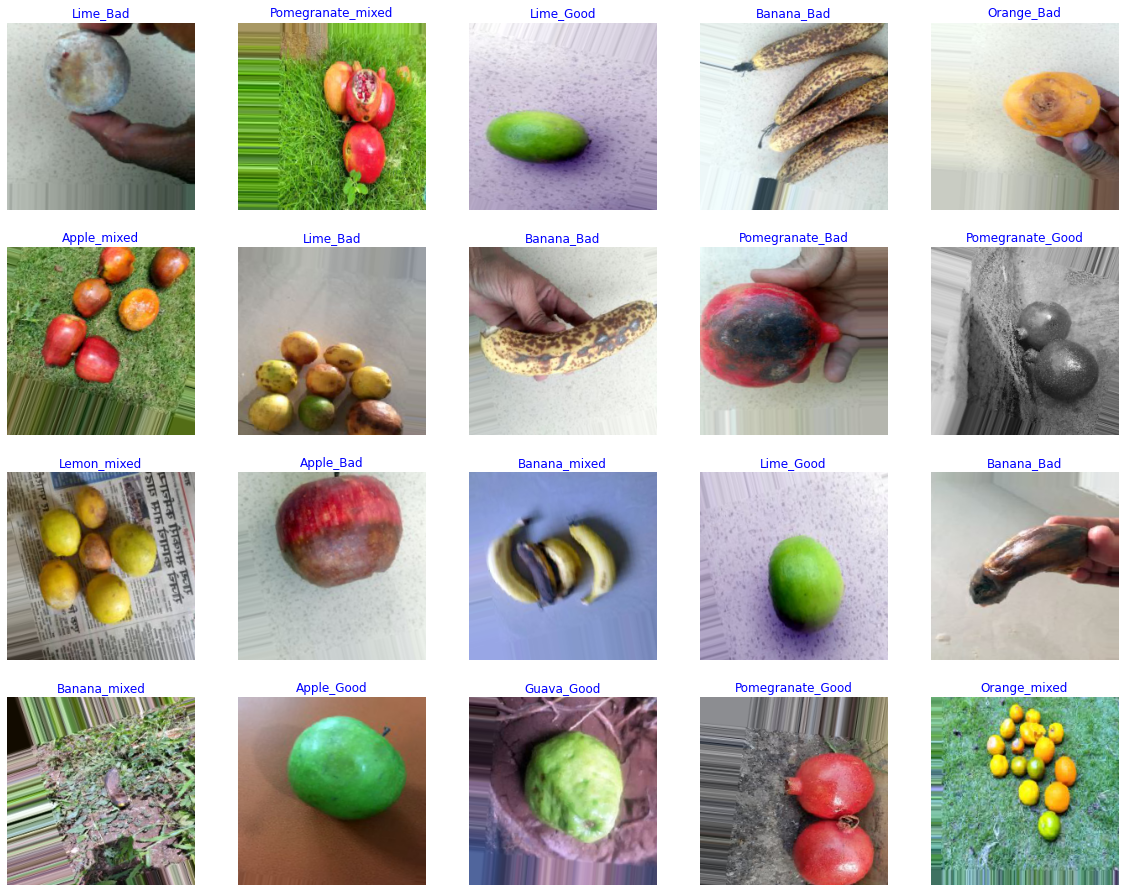

In [8]:
"""
Display a batch of images with their corresponding class labels.
Args:
        gen: Data generator providing images and labels.
"""
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())   

    # Get a sample batch.
    images,labels=next(gen) 
    plt.figure(figsize=(20, 20))
    length=len(labels)

    # Show up to 25 images.
    if length<25: 
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()

# Visualize samples from the training generator.
show_image_samples(train_gen )

# Model Definition: Define and compile the deep learning model using EfficientNetB5

In [9]:
# Input image shape.
img_shape=(img_size[0], img_size[1], 3)
model_name='EfficientNetB5'

# Load the EfficientNetB5 base model with pre-trained weights.
base_model=tf.keras.applications.efficientnet.EfficientNetB5(include_top=False, 
                                                             weights="imagenet",
                                                             input_shape=img_shape, 
                                                             pooling='max') 

# Fine-tune the base model
base_model.trainable=True

# Add custom layers on top of the base model.
x=base_model.output

x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)

x = Dense(1024, 
          kernel_regularizer = regularizers.l2(l = 0.016),
          activity_regularizer=regularizers.l1(0.006), 
          bias_regularizer=regularizers.l1(0.006) ,
          activation='relu')(x)

x=Dropout(rate=.3, seed=123)(x)

x = Dense(128, 
          kernel_regularizer = regularizers.l2(l = 0.016),
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006),
          activation='relu')(x)

x=Dropout(rate=.45, seed=123)(x)

output=Dense(class_count, activation='softmax')(x)

# Compile the model
model=Model(inputs=base_model.input, outputs=output)
# Initial learning rate.
lr=.001 
model.compile(Adamax(learning_rate=lr), 
              loss='categorical_crossentropy', 
              metrics=['accuracy']) 

115277824/115263384 [==============================] - 1s 0us/step


# Training with Callbacks: Implement callbacks for adaptive learning and user control during training

In [10]:
"""
Custom callback to query the user during training.
"""
class ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch): 
        super(ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        # Query user on a specified epoch.
        self.ask=True 
        
    def on_train_begin(self, logs=None): 
        """Initialize training."""
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: 
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False 
        if self.epochs == 1:
            self.ask=False 
        else:
            print('Training will proceed until epoch', ask_epoch,' then you will be asked to') 
            print(' enter H to halt training or enter an integer for how many more epochs to run then be asked again')  
        self.start_time= time.time() 
        
    def on_train_end(self, logs=None):  
        tr_duration=time.time() - self.start_time         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg, flush=True) 
        
    def on_epoch_end(self, epoch, logs=None): 
        """Query user at specified epochs."""
        if self.ask: 
            if epoch + 1 ==self.ask_epoch: 
                print('\n Enter H to end training or  an integer for the number of additional epochs to run then ask again')
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': 
                    print ('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True
                else: 
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)

In [11]:
# Initialize callbacks.
epochs=40
ask_epoch=5
ask=ASK(model, epochs,  ask_epoch)
rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2,verbose=1)
estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, verbose=1,restore_best_weights=True)
callbacks=[rlronp, estop, ask]

# Model Training: Train the model with training and validation datasets.

In [12]:
history=model.fit(x=train_gen,  
                  epochs=epochs, 
                  verbose=1, 
                  callbacks=callbacks,  
                  validation_data=valid_gen,
                  validation_steps=None,  
                  shuffle=False,  
                  initial_epoch=0)

Training will proceed until epoch 5  then you will be asked to
 enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/40
180/180 [==============================] - 130s 581ms/step - loss: 23.5953 - accuracy: 0.6142 - val_loss: 17.1013 - val_accuracy: 0.9089
Epoch 2/40
180/180 [==============================] - 93s 516ms/step - loss: 13.6713 - accuracy: 0.8808 - val_loss: 10.3027 - val_accuracy: 0.9427
Epoch 3/40
180/180 [==============================] - 93s 518ms/step - loss: 8.5494 - accuracy: 0.9389 - val_loss: 6.5317 - val_accuracy: 0.9703
Epoch 4/40
180/180 [==============================] - 93s 515ms/step - loss: 5.5196 - accuracy: 0.9647 - val_loss: 4.2682 - val_accuracy: 0.9785
Epoch 5/40
180/180 [==============================] - 93s 514ms/step - loss: 3.6687 - accuracy: 0.9717 - val_loss: 2.8549 - val_accuracy: 0.9775

 Enter H to end training or  an integer for the number of additional epochs to run then ask again


 10


you entered  10  Training will continue to epoch  15
Epoch 6/40
180/180 [==============================] - 93s 513ms/step - loss: 2.4912 - accuracy: 0.9814 - val_loss: 1.9976 - val_accuracy: 0.9795
Epoch 7/40
180/180 [==============================] - 93s 514ms/step - loss: 1.7908 - accuracy: 0.9825 - val_loss: 1.4408 - val_accuracy: 0.9908
Epoch 8/40
180/180 [==============================] - 93s 515ms/step - loss: 1.3572 - accuracy: 0.9864 - val_loss: 1.1184 - val_accuracy: 0.9857
Epoch 9/40
180/180 [==============================] - 93s 518ms/step - loss: 1.0874 - accuracy: 0.9886 - val_loss: 0.8905 - val_accuracy: 0.9918
Epoch 10/40
180/180 [==============================] - 93s 517ms/step - loss: 0.9104 - accuracy: 0.9911 - val_loss: 0.7732 - val_accuracy: 0.9846
Epoch 11/40
180/180 [==============================] - 92s 513ms/step - loss: 0.8033 - accuracy: 0.9886 - val_loss: 0.7186 - val_accuracy: 0.9795
Epoch 12/40
180/180 [==============================] - 93s 518ms/step - los

 20


you entered  20  Training will continue to epoch  35
Epoch 16/40
180/180 [==============================] - 94s 519ms/step - loss: 0.5653 - accuracy: 0.9947 - val_loss: 0.5224 - val_accuracy: 0.9877
Epoch 17/40
180/180 [==============================] - 93s 518ms/step - loss: 0.5483 - accuracy: 0.9950 - val_loss: 0.5356 - val_accuracy: 0.9785

Epoch 00017: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 18/40
180/180 [==============================] - 93s 516ms/step - loss: 0.5255 - accuracy: 0.9958 - val_loss: 0.4716 - val_accuracy: 0.9898
Epoch 19/40
180/180 [==============================] - 93s 517ms/step - loss: 0.5023 - accuracy: 0.9964 - val_loss: 0.4604 - val_accuracy: 0.9908
Epoch 20/40
180/180 [==============================] - 93s 518ms/step - loss: 0.4933 - accuracy: 0.9978 - val_loss: 0.4473 - val_accuracy: 0.9908
Epoch 21/40
180/180 [==============================] - 93s 515ms/step - loss: 0.4829 - accuracy: 0.9983 - val_loss: 0.4376 - val_accurac

 H


you entered  H  Training halted on epoch  35  due to user input

training elapsed time was 1.0 hours,  4.0 minutes, 25.48 seconds)


# Plot Training Results: Visualize training and validation loss and accuracy.

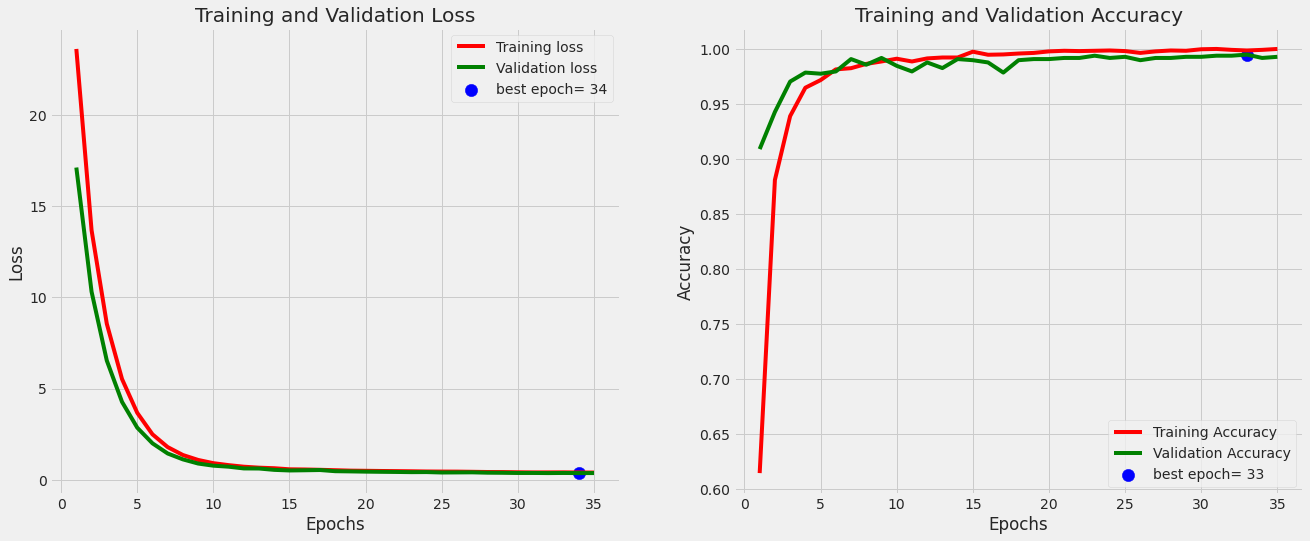

In [13]:
"""
Plot training and validation metrics over epochs.
Args:
        tr_data: Training history object.
        start_epoch: Starting epoch for the plot.
"""
def tr_plot(tr_data, start_epoch):

    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout    
    plt.show()

# Plot training results.
tr_plot(history,0)

# Evaluate Model on Test Data: Use the test dataset to generate predictions, compute metrics, and visualize results.

16/16 [==============================] - 21s 1s/step
there were 6 in 976 tests for an accuracy of  99.39


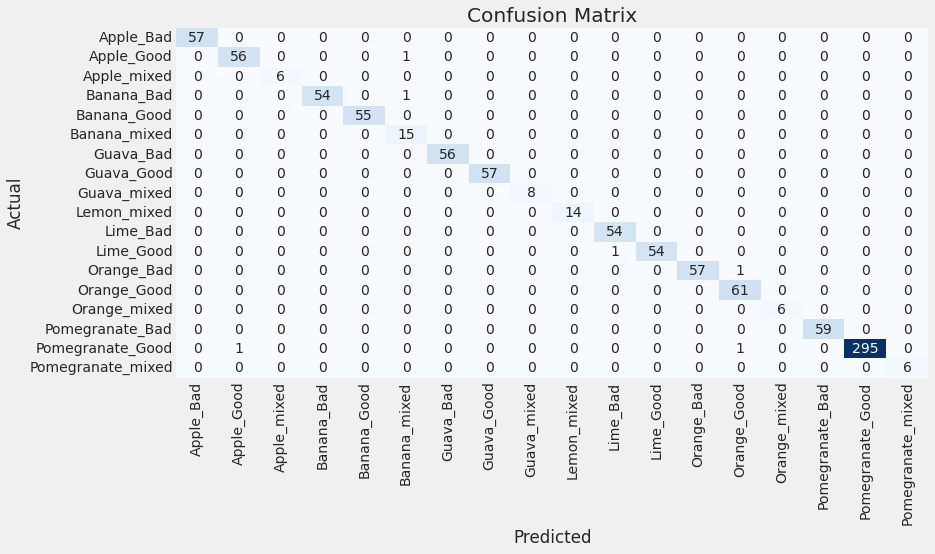

Classification Report:
----------------------
                    precision    recall  f1-score   support

        Apple_Bad     1.0000    1.0000    1.0000        57
       Apple_Good     0.9825    0.9825    0.9825        57
      Apple_mixed     1.0000    1.0000    1.0000         6
       Banana_Bad     1.0000    0.9818    0.9908        55
      Banana_Good     1.0000    1.0000    1.0000        55
     Banana_mixed     0.8824    1.0000    0.9375        15
        Guava_Bad     1.0000    1.0000    1.0000        56
       Guava_Good     1.0000    1.0000    1.0000        57
      Guava_mixed     1.0000    1.0000    1.0000         8
      Lemon_mixed     1.0000    1.0000    1.0000        14
         Lime_Bad     0.9818    1.0000    0.9908        54
        Lime_Good     1.0000    0.9818    0.9908        55
       Orange_Bad     1.0000    0.9828    0.9913        58
      Orange_Good     0.9683    1.0000    0.9839        61
     Orange_mixed     1.0000    1.0000    1.0000         6
  Pomegr

In [14]:
# Initialize lists to store predictions and ground truths.
y_pred= []
y_true=test_gen.labels
errors=0

# Generate predictions on the test dataset.
preds=model.predict(test_gen, steps=test_steps, verbose=1) # predict on the test set
tests=len(preds)

# Compare predictions with ground truth to calculate accuracy and misclassification count.
for i, p in enumerate(preds):
        # Predicted class index.
        pred_index=np.argmax(p) 
        # Ground truth class index.
        true_index=test_gen.labels[i]  
        if pred_index != true_index:                                          
            errors=errors + 1
        y_pred.append(pred_index)

# Calculate accuracy.
acc=( 1-errors/tests) * 100
print(f'there were {errors} in {tests} tests for an accuracy of {acc:6.2f}')

# Convert predictions and ground truth into numpy arrays for further evaluation.
ypred=np.array(y_pred)
ytrue=np.array(y_true)

# Generate the confusion matrix.
cm = confusion_matrix(ytrue, ypred )

# Plot the confusion matrix.
plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Generate and display the classification report.
clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
print("Classification Report:\n----------------------\n", clr)

# Save the Trained Model: Save the model with a filename indicating its accuracy.

In [15]:
subject='Indian Fruit' 
acc=str(( 1-errors/tests) * 100)
index=acc.rfind('.')
acc=acc[:index + 3]
save_id= subject + '_' + str(acc) + '.h5' 
model_save_loc=os.path.join(working_dir, save_id)

# Save the model in H5 format.
model.save(model_save_loc)
print ('model was saved as ' , model_save_loc ) 

model was saved as  ./Indian Fruit_99.38.h5
